In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node

from nipype.algorithms.misc import Gunzip

/home/soyeon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [3]:
experiment_dir = '/home/soyeon/output'
output_dir = 'datasink'
working_dir = 'workingdir'

subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', 
               '16', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28']

task_list = ['socialcomparison']

fwhm = [6]

with open('/home/soyeon/socialcomparison/task-socialcomparison_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

iso_size = 4

In [4]:
# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

In [5]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                    name="segmentation", mem_gb=4)

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

In [6]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'func',
                'sub-{subject_id}_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/home/soyeon/socialcomparison/'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [7]:
# Create a preprocessing workflow# Creat 
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, mcflirt, [('func', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),
                 
                 (coregwf, smooth, [('applywarp.out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),

                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),

                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 ])

181028-20:43:27,15 nipype.workflow INFO:
	 Generated workflow graph: /home/soyeon/output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


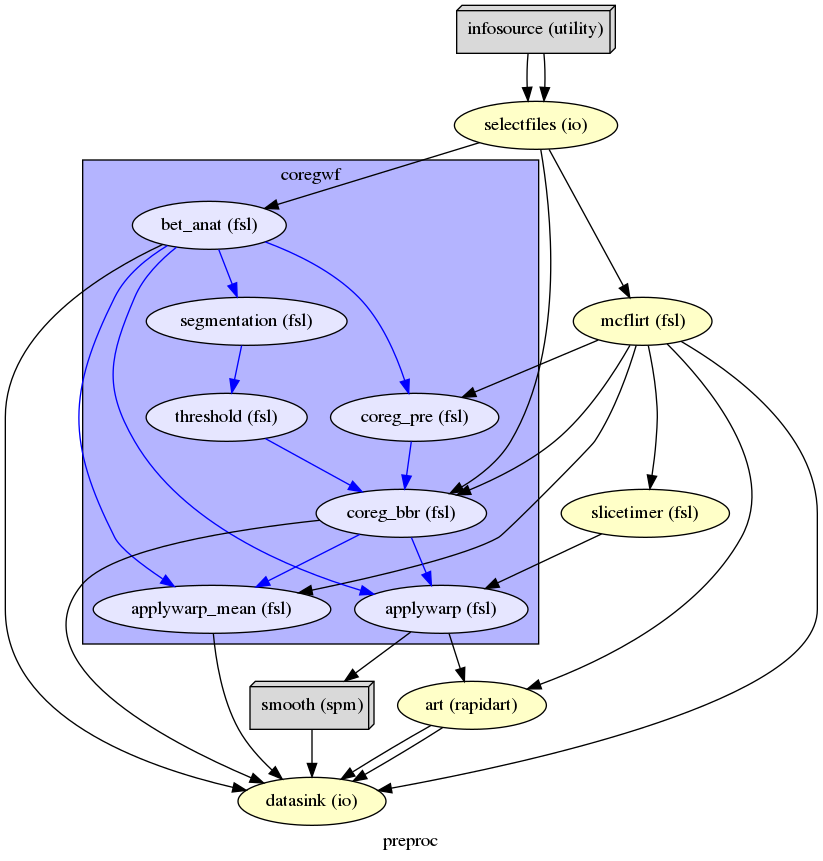

In [8]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

181028-20:43:28,552 nipype.workflow INFO:
	 Generated workflow graph: /home/soyeon/output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


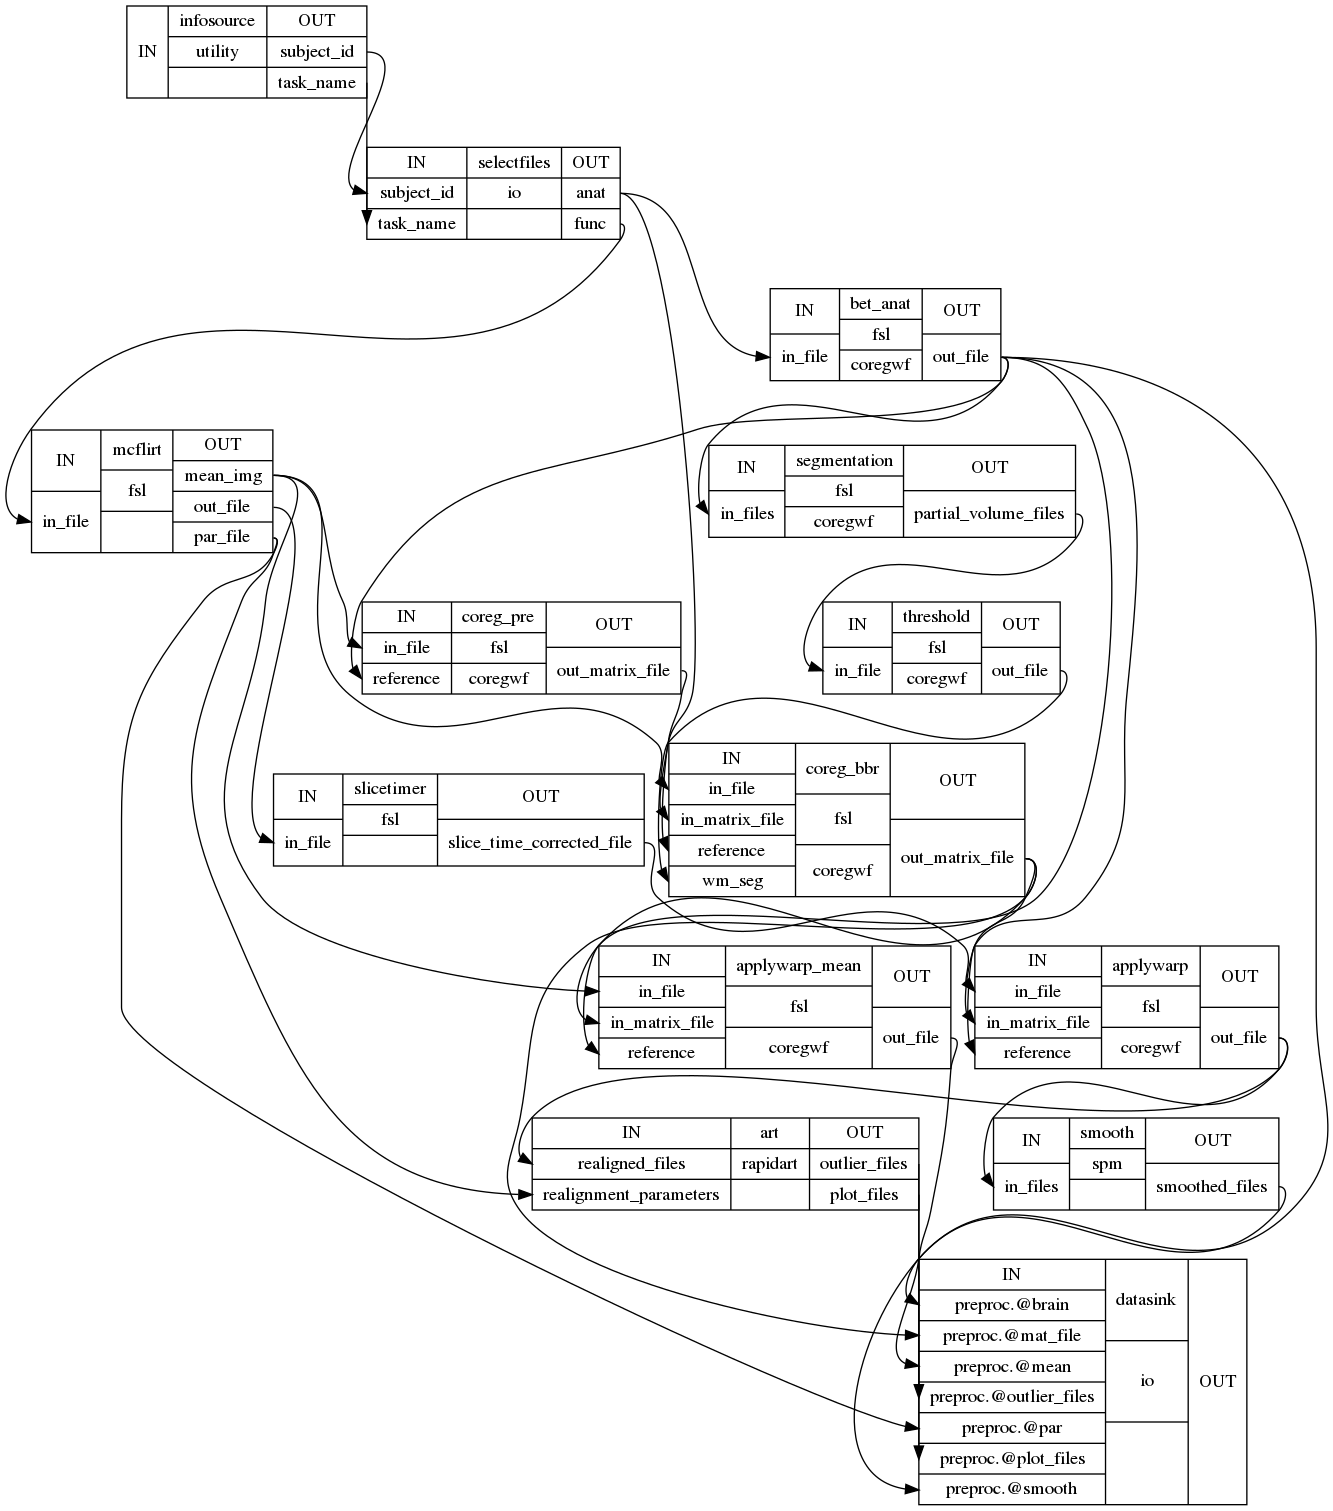

In [9]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.png'))

In [10]:
preproc.run('MultiProc', plugin_args={'n_procs': 2})

181028-20:43:29,548 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
181028-20:43:29,815 nipype.workflow INFO:
	 Running in parallel.
181028-20:43:29,829 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 28 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 2/2.
181028-20:43:29,918 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/soyeon/output/workingdir/preproc/_subject_id_28_task_name_socialcomparison/selectfiles".
181028-20:43:29,970 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181028-20:43:29,920 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/soyeon/output/workingdir/preproc/_subject_id_27_task_name_socialcomparison/selectfiles".
181028-20:43:29,981 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".
181028-20:43:29,989 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")


RuntimeError: Workflow did not execute cleanly. Check log for details

In [25]:
from nilearn import image, plotting
out_path = '/home/soyeon/output/datasink/preproc/sub-06/task-socialcomparison'

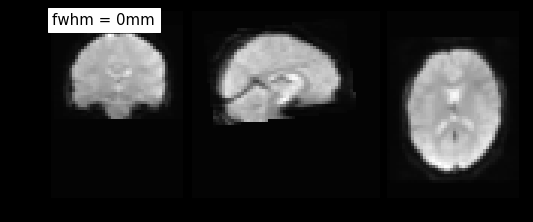

In [26]:
plotting.plot_epi(opj(out_path, 'sub-06_task-socialcomparison_bold_mean.nii.gz'),
                  title="fwhm = 0mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

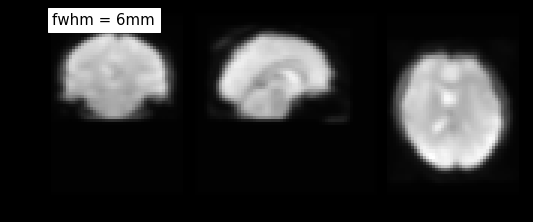

In [21]:
plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-6_ssub-01_task-socialcomparison_bold.nii')),
                  title="fwhm = 6mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');